In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("allocine_spider_clean.parquet")
df = df[df['french_first_week_boxoffice'].notna()]
features_of_interest = [
    'actors',
    'critics_score',
    'date',
    'director',
    'editor',
    'genre',
    'langage',
    'length',
    'nationality',
    'viewers_score'
]

info_film = ['french_visa', 'title', 'vo_title', 'url']


list_categorical_features = ['actors', 'genre', 'langage', 'nationality']
for col in list_categorical_features:
    df[col] = df[col].mask(df[col].isna(), ['no value'])

target = 'french_first_week_boxoffice'

df = df.sort_values('date')

X, y = (
    df[features_of_interest],
    df[target]
)
# df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

In [41]:
df.sort_values('french_first_week_boxoffice', ascending=False).head(1)

,actors,critics_score,date,director,editor,genre,langage,length,nationality,viewers_score,french_first_week_boxoffice,french_visa,title,vo_title,url
1462,"[Tom Holland, Zendaya, Benedict Cumberbatch]",3.3,2021-12-15,Jon Watts,Sony Pictures Releasing France,"[Action, Aventure, Fantastique]",[Anglais],148.0,[U.S.A.],3.9,2867515.0,-,Spider-Man: No Way Home,None,/video/player_gen_cmedia=19593625&cfilm=256880...


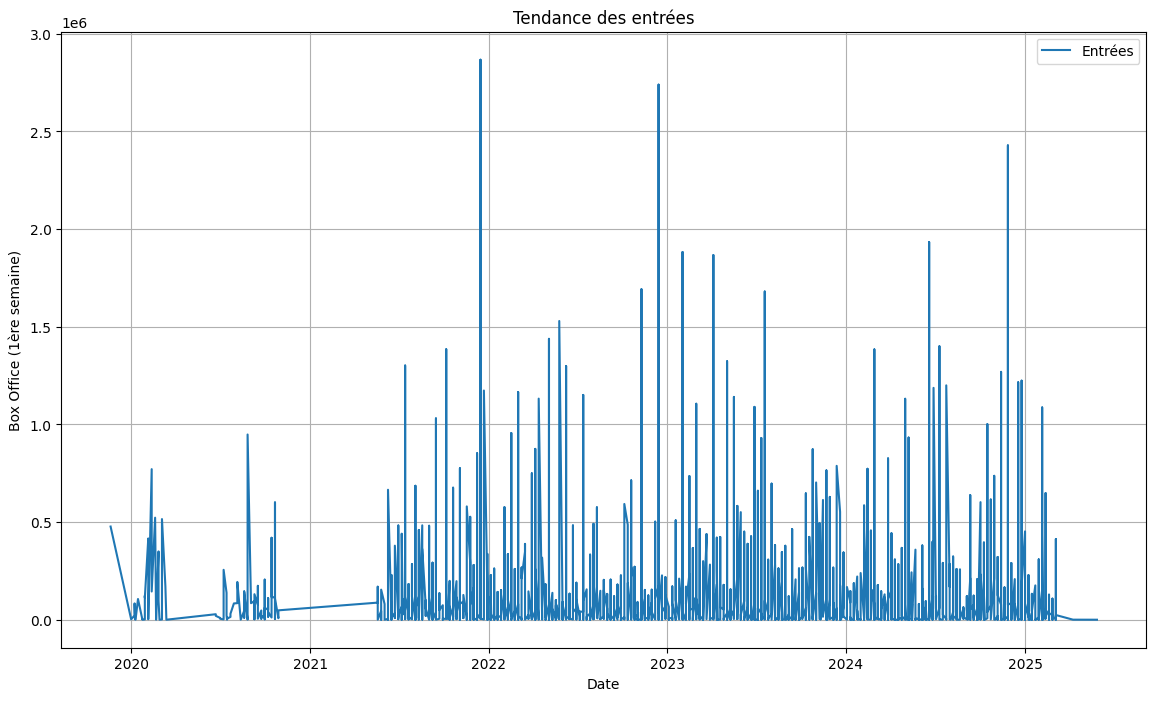

In [42]:
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_time = df[['date', 'french_first_week_boxoffice']]
plt.figure(figsize=(14, 8))
plt.plot(df_time['date'], df_time['french_first_week_boxoffice'])
plt.title('Tendance des entrées')
plt.xlabel('Date')
plt.ylabel('Box Office (1ère semaine)')
plt.legend(['Entrées'])
plt.grid(True)
plt.show()

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import numpy as np

numerical_features = ['critics_score', 'length', 'viewers_score']
date_feature = ['date']
categorical_features = ['director', 'editor']
list_categorical_features = ['actors', 'genre', 'langage', 'nationality']

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlbs = {}  # Stocke un MultiLabelBinarizer pour chaque colonne
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.mlbs[col] = MultiLabelBinarizer()
            self.mlbs[col].fit(X[col])
        return self
    
    def transform(self, X):
        transformed_list = []
        for col in X.columns:
            transformed = self.mlbs[col].transform(X[col])
            new_columns = [f"{col}_{label}" for label in self.mlbs[col].classes_]
            transformed_list.append(pd.DataFrame(transformed, columns=new_columns, index=X.index))
        
        return pd.concat(transformed_list, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # Collecter tous les noms de colonnes de sortie
        feature_names = []
        for col in self.mlbs.keys():
            feature_names.extend([f"{col}_{label}" for label in self.mlbs[col].classes_])
        return np.array(feature_names)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Bourin... à changer mais j'ai même pas vérifier s'il manquait des données...
    ('scaler', StandardScaler())
])

class CustomDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = ['year', 'month', 'day', 'dayofweek', 'is_summer', 'is_holiday', 'quarter']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dt_series = pd.to_datetime(X['date'], unit='ms')
        month = dt_series.dt.month
        year = dt_series.dt.year
        
        result = pd.DataFrame({
            'year': year,
            'month': month,
            'day': dt_series.dt.day,
            'dayofweek': dt_series.dt.dayofweek,
            'is_summer': month.isin([6, 7, 8]).astype(int),
            'is_holiday': ((month == 12) | (month == 2) | 
                           (month == 4) | (month == 10)).astype(int),
            'quarter': dt_series.dt.quarter
        })
        return result
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out)

date_transformer = Pipeline(steps=[
    ('date_features', CustomDateTransformer())
])

# Toujours bourin :p
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_categorical_transformer = Pipeline(steps=[
    ('multi_label', MultiLabelBinarizerTransformer())
])

# Création du préprocesseur (sans les colonnes déjà transformées)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough',
    sparse_threshold=0 # J'ai pas compris revenir la dessus
)

In [44]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
    ))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 83414.92541387092
RMSE: 243429.39047839027
R²: 0.2623724725069333


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [' Diablo', ' Li Xuejian', ' Mohanlal', ' Non', ' Shivarajkumar', 'Abdirisak Mohamed', 'Achouackh Abakar', 'Adeel Akhtar', 'Adrián Rossi', 'Ai Hashimoto', 'Aishwarya Rajesh', 'Alaina Clifford', 'Aldis Hodge', 'Alec Baldwin', 'Aleksandra Revenko', 'Alessandro Nivola', 'Alva Brynsmo Ramstad', 'Alysson Paradis', 'America Ferrera', 'Amirhosein Fathi', 'Amrullah Safi', 'Amy Sedaris', 'Ana Esther Alborg', 'Anaswara Rajan', 'Anh Tran-Nghia', 'Anna Choupisson', 'Anna Mangiocavallo', 'Annabel

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def create_time_series(df):
    df['date_dt'] = pd.to_datetime(df['date'], unit='ms')
    df = df.sort_values('date_dt')
    
    # Création d'une série temporelle hebdomadaire
    weekly_data = df.resample('W', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
    
    # Créer également des séries mensuelles et trimestrielles pour analyser différentes granularités
    monthly_data = df.resample('M', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
    quarterly_data = df.resample('Q', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
    
    return weekly_data, monthly_data, quarterly_data

def train_sarima(data, seasonal_periods=52):
    # Tester différentes combinaisons d'ordres
    orders = [(1, 1, 1), (1, 1, 0), (0, 1, 1)]
    seasonal_orders = [(1, 1, 1, seasonal_periods), (0, 1, 1, seasonal_periods)]
    
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    for order in orders:
        for seasonal_order in seasonal_orders:
            try:
                model = SARIMAX(
                    data, 
                    order=order, 
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False, 
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = results
            except:
                continue
    
    print(f"Meilleur ordre SARIMA: {best_order}")
    print(f"Meilleur ordre saisonnier: {best_seasonal_order}")
    print(f"AIC: {best_aic}")
    
    return best_model

# Fonction pour ajouter les caractéristiques du marché au jeu de données
def add_market_features(df, weekly_data, sarima_model):
    # Assurer que nous avons une copie
    df_with_market = df.copy()
    
    # Créer une colonne pour la semaine de l'année normalisée (pour joindre avec les données hebdomadaires)
    df_with_market['date_dt'] = pd.to_datetime(df_with_market['date'], unit='ms')
    df_with_market['year_week'] = df_with_market['date_dt'].dt.strftime('%Y-%U')
    
    # Créer un dataframe avec la tendance du marché
    market_df = pd.DataFrame({
        'year_week': weekly_data.index.strftime('%Y-%U'),
        'market_avg_boxoffice': weekly_data.values
    })
    
    # Joindre avec les données du film
    df_with_market = pd.merge(df_with_market, market_df, on='year_week', how='left')
    
    # Imputer les valeurs manquantes (si un film sort dans une semaine sans données historiques)
    df_with_market['market_avg_boxoffice'].fillna(
        df_with_market['market_avg_boxoffice'].mean(), inplace=True
    )
    
    # Calculer des statistiques glissantes du marché
    market_rolling = weekly_data.rolling(window=4).mean()
    market_trend = weekly_data.pct_change(periods=4).fillna(0)
    
    # Créer un dataframe avec ces statistiques
    market_stats_df = pd.DataFrame({
        'year_week': weekly_data.index.strftime('%Y-%U'),
        'market_4w_avg': market_rolling.values,
        'market_trend': market_trend.values
    })
    
    # Joindre avec les données du film
    df_with_market = pd.merge(df_with_market, market_stats_df, on='year_week', how='left')
    
    # Imputer les valeurs manquantes
    df_with_market['market_4w_avg'].fillna(df_with_market['market_avg_boxoffice'], inplace=True)
    df_with_market['market_trend'].fillna(0, inplace=True)
    
    return df_with_market

/tmp/ipykernel_29173/4179245554.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_data = df.resample('W', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
/tmp/ipykernel_29173/4179245554.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
/tmp/ipykernel_29173/4179245554.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data = df.resample('M', on='date_dt')['french_first_week_boxoffice'].mean().fillna(method='ffill')
/tmp/ipykernel_29173/4179245554.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = df.resample('Q', on='date_dt')['fren

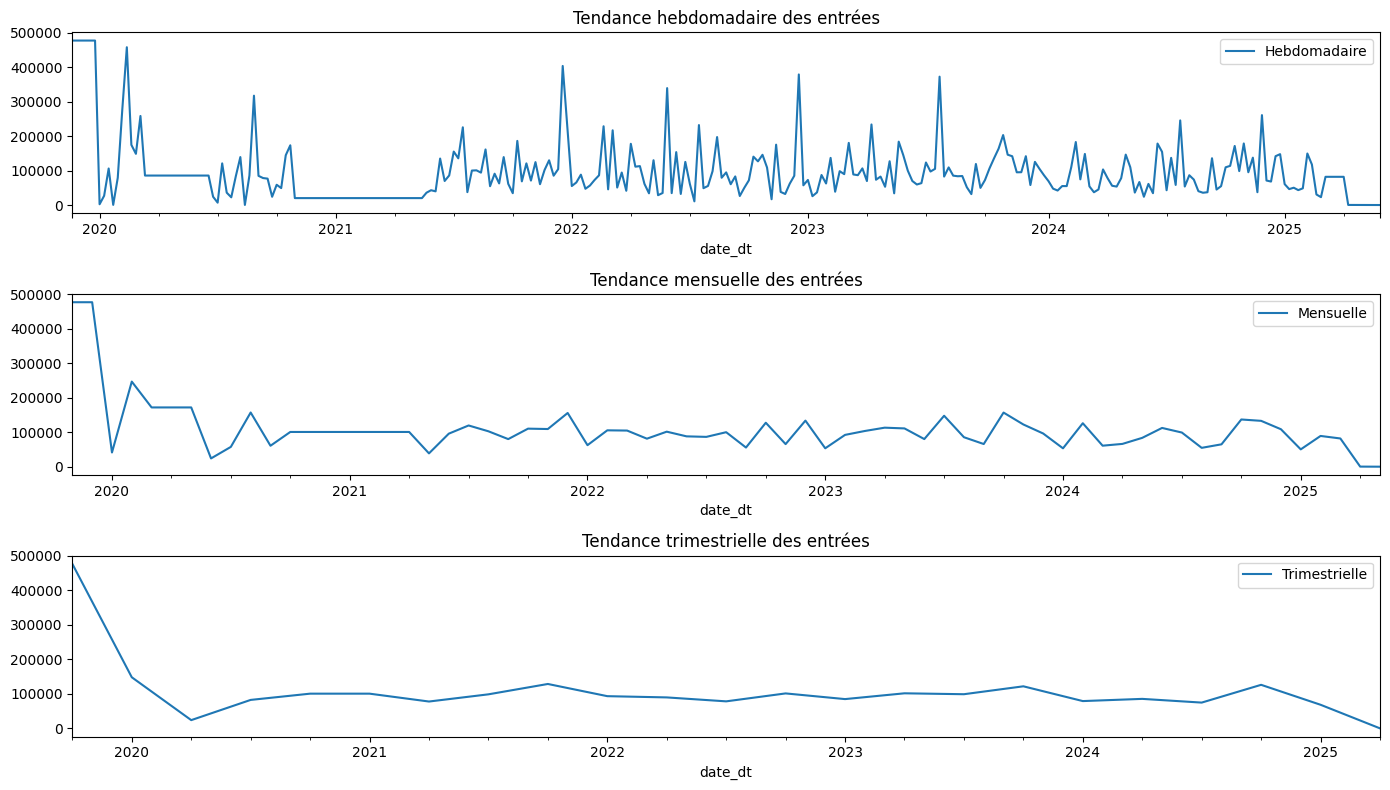

In [46]:
weekly_data, monthly_data, quarterly_data = create_time_series(df)
    
# Visualiser les tendances temporelles
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
weekly_data.plot(title='Tendance hebdomadaire des entrées', label='Hebdomadaire')
plt.legend()

plt.subplot(3, 1, 2)
monthly_data.plot(title='Tendance mensuelle des entrées', label='Mensuelle')
plt.legend()

plt.subplot(3, 1, 3)
quarterly_data.plot(title='Tendance trimestrielle des entrées', label='Trimestrielle')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
sarima_weekly = train_sarima(weekly_data, seasonal_periods=52)
df_with_market = add_market_features(df, weekly_data, sarima_weekly)

Meilleur ordre SARIMA: (1, 1, 1)
Meilleur ordre saisonnier: (0, 1, 1, 52)
AIC: 4623.261105894601


/tmp/ipykernel_29173/4179245554.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_with_market['market_avg_boxoffice'].fillna(
/tmp/ipykernel_29173/4179245554.py:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [48]:
df_with_market = df_with_market.sort_values('date_dt')
train_size = int(len(df_with_market) * 0.9)
train_df = df_with_market.iloc[:train_size]
test_df = df_with_market.iloc[train_size:]

X_train = train_df.drop(['french_first_week_boxoffice', 'date_dt', 'year_week', 'title', 'vo_title', 'url', 'french_visa'], axis=1, errors='ignore')
y_train = train_df['french_first_week_boxoffice']

X_test = test_df.drop(['french_first_week_boxoffice', 'date_dt', 'year_week', 'title', 'vo_title', 'url', 'french_visa'], axis=1, errors='ignore')
y_test = test_df['french_first_week_boxoffice']

In [49]:
df_with_market.head()

,actors,critics_score,date,director,editor,genre,langage,length,nationality,viewers_score,french_first_week_boxoffice,french_visa,title,vo_title,url,date_dt,year_week,market_avg_boxoffice,market_4w_avg,market_trend
0,"[Thierry Lhermitte, Michèle Laroque, Nicole Fe...",2.8,2019-11-20,Fabrice Bracq,SND,[Comédie],[Français],97.0,[France],2.1,477116.0,149485,Joyeuse retraite !,None,/article/fichearticle_gen_carticle=18711210.html,2019-11-20,2019-46,97443.125492,97443.125492,0.000000
1,"[Bjarki Thor, Ragnar Jónsson, Sigurmar Alberts...",2.7,2020-01-01,Rúnar Rúnarsson,Jour2fête,[Drame],[Islandais],79.0,"[Islande, France]",3.2,2257.0,152198,Echo,None,/article/fichearticle_gen_carticle=18686432.html,2020-01-01,2020-00,97443.125492,97443.125492,0.000000
2,"[Thomas Guy, Benjamin Voisin, Isabelle Carré]",3.4,2020-01-08,Benjamin Parent,Ad Vitam,[Comédie dramatique],[Français],88.0,[France],3.9,21774.0,149112,Un vrai bonhomme,None,/article/fichearticle_gen_carticle=18694955.html,2020-01-08,2020-01,2257.000000,358401.250000,-0.995269
3,"[Chantal Lauby, Camille Chamoux, Giovanni Pucci]",3.1,2020-01-08,Jézabel Marques,StudioCanal,[Comédie],[Français],98.0,[France],2.5,83565.0,149961,SOL,None,/article/fichearticle_gen_carticle=18699854.html,2020-01-08,2020-01,2257.000000,358401.250000,-0.995269
4,"[ Rajinikanth, Nayanthara, Nivetha Thomas]",3.3,2020-01-09,A.R. Murugadoss,Friday Entertainment,"[Action, Thriller]","[Hindi, Tamoul]",159.0,[Inde],NaN,1559.0,-,Darbar,None,/personne/fichepersonne_gen_cpersonne=708164.html,2020-01-09,2020-01,2257.000000,358401.250000,-0.995269


In [50]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
    ))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 80240.22872063304
RMSE: 203717.6785881856
R²: 0.33521851879560594


/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [' Cali', ' Kanichiro', ' Mammootty', ' Samuthirakani', ' Siddique', ' Tai-Bo', 'Aaron Pierre', "Adeline D'Hermy", 'Adrien Antoine', 'Agnès Sourdillon', 'Alanna Ubach', 'Alexis Bourtereau', 'Alice Daubelcour', 'Allu Arjun', 'Amanda Jansson', 'Amaury Foucher', 'Andrea Dolente', 'Andrea Fuorto', 'Andrew Garfield', 'Andréa Bescond', 'Angelina Jolie', 'Angèle Metzger', 'Anh Tran-Nghia', 'Anna Mangiocavallo', 'Anna Mouglalis', 'Anthony Kavanagh', 'Anthony Mackie', 'Anthony Morganti', 'Ant